<span style='color:#009999'> <span style='font-family:serif'> <font size="15"> **ECCOv4 from NASA Earth Data Cloud**<span style='color:#0066cc'> 

<img src="img/ECCOv4.png" alt="drawing" width="750"/>    


<span style='color:#0066cc'><font size="5"> **About the "Estimating the Circulation and Climate of the Ocean" [ECCO](https://ecco-group.org/) consortium**
1. <font size="3"><span style='color:Black'> Uses a combination of assimilated data from (various sources) to constrain the simulated global ocean and atmosphere model.
3. <font size="3"><span style='color:Black'> Remains widely used by climate scientists.
4. <font size="3"><span style='color:Black'> ECCO belongs to a hierarchy of global models that all share the same grid topology (Cube Sphere), but differ in horizontal resolution. 



<span style='color:#ff6666'><font size="5">**Requirements**
1. <font size="3"><span style='color:Black'> Have a Bearer Token for EarthData in the Cloud (See `GetStarted` Notebook).
2. <font size="3"><span style='color:Black'> Upload the Bearer Token from local file `token.json`



<font size="3"><span style='color:Black'> This notebook makes use of [xarray](https://xarray.dev/) with [pydap](https://pydap.github.io/pydap/) as an  engine` to enable parallelism. However, this notebook also provides OPeNDAP savy approach that can accelerate scientific workflows when remote dataset are available via Hyrax in the Cloud (cloud OPeNDAP urls).


 <span style='color:#ff6666'><font size="5"> **Objectives**
 
 
- <font size="3"><span style='color:Black'> Demostrate how to use NASA's `Common Metadata Repository` ([CMR](https://cmr.earthdata.nasa.gov/search)) to find `cloud OPeNDAP URLS` associated with a collection.
- <font size="3"><span style='color:Black'> Demonstrate the use of `Constraint Expressions` to reduce metadata during Virtual Dataset creation
- <font size="3"><span style='color:Black'> Use `pydap`'s `consolidate_metadata` to accelerate data cube creation via `xarray.open_mfdataset`.
- <font size="3"><span style='color:Black'> Demonstrate an advanced workflow for remote access and plotting of **Level 4** with complex Topology ECCOv4 Data avaiable via Hyrx in the Cloud / cloud OPeNDAP.



<span style='color:#ff6666'><font size="5">**Browsing Data**:

<font size="3"><span style='color:Black'> Broad information about the dataset can be found in the PODAAC website (see [here](https://podaac.jpl.nasa.gov/cloud-datasets?view=list&ids=Projects&values=ECCO)).


<font size="3"><span style='color:Black'> Some Collections of interest can be found following the links below:

- <font size="3"> [Native grid](https://podaac.jpl.nasa.gov/dataset/ECCO_L4_GEOMETRY_LLC0090GRID_V4R4)
- <font size="3"> [Temperature and Salinity](https://podaac.jpl.nasa.gov/dataset/ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4)
- <font size="3"> [Velocities](https://podaac.jpl.nasa.gov/dataset/ECCO_L4_OCEAN_VEL_LLC0090GRID_MONTHLY_V4R4)
- <font size="3"> [Mixed layer depth](https://podaac.jpl.nasa.gov/dataset/ECCO_L4_MIXED_LAYER_DEPTH_LLC0090GRID_MONTHLY_V4R4)


In [35]:
import matplotlib.pyplot as plt
import numpy as np
import requests
from pydap.client import open_url
from pydap.net import create_session
import json
import cartopy.crs as ccrs
import xarray as xr
import datetime as dt
from pydap.client import consolidate_metadata



<span style='color:#ff6666'><font size="5">**Finding Cloud OPeNDAP URLs with NASA's CMR**:

<span style='font-family:serif'> <font size="3"><span style='color:Black'> Below we illustrate how to find OPeNDAP URLs via the **CMR**

<span style='color:#0066cc'><font size="3.5"> **To find (cloud) OPeNDAP URL you will need:**

* One of `Collection Concept ID` or `dataset DOI`
* Time Range


Here, we will use the Collection Concept ID associated with the [Temperature and Salinity](https://podaac.jpl.nasa.gov/dataset/ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4). For example:

<img src="img/ECCO_conceptID_doi.png" alt="drawing" width="750"/>    





In [4]:
session = requests.Session()

In [5]:
# CMR API base url
cmrurl='https://cmr.earthdata.nasa.gov/search/'
doi = '10.5067/ECL5M-OTS44'                   # Daymet V4R1 DOI - define the DOI as the variable `daymet_doi`
doisearch = cmrurl + 'collections.json?doi=' + doi
print(doisearch)

concept_id = session.get(doisearch).json()['feed']['entry'][0]['id']
print(concept_id)

https://cmr.earthdata.nasa.gov/search/collections.json?doi=10.5067/ECL5M-OTS44
C1991543728-POCLOUD


<span style='font-family:serif'> <font size="5.5"><span style='color:#0066cc'> **Specify time range**

<font size="3"><span style='color:Black'> This dataset covers `01-01-1992` to `01-18-2018`. 


In [8]:
start_date =  dt.datetime(1992, 1, 1)
end_date = dt.datetime(2017, 12, 31)

print(start_date,end_date,sep='\n')

dt_format = '%Y-%m-%dT%H:%M:%SZ' # format requirement for datetime search
temporal_str = start_date.strftime(dt_format) + ',' + end_date.strftime(dt_format)
print(temporal_str)

1992-01-01 00:00:00
2017-12-31 00:00:00
1992-01-01T00:00:00Z,2017-12-31T00:00:00Z


<span style='font-family:serif'> <font size="5.5"><span style='color:#0066cc'> **Get all available cloud OPeNDAP URLs via CMR**

The cell below will search/find all OPeNDAP URLs associated with the Collection concept ID.

The results wll be stored in the variable `granules_urls`.
    

In [12]:
%%time
cmr_url = 'https://cmr.earthdata.nasa.gov/search/granules'

cmr_response = session.get(cmr_url, 
                            params={
                                'concept_id': concept_id,
                                'temporal': temporal_str,
                                'page_size': 500,
                                },
                            headers={
                                'Accept': 'application/json'
                                }
                            )

granules = cmr_response.json()['feed']['entry']

granules_urls = []

for granule in granules:
    item = next((item['href'] for item in granule['links'] if "opendap" in item["href"]), None)
    if item != None:
        granules_urls.append(item)

CPU times: user 25 ms, sys: 7.43 ms, total: 32.4 ms
Wall time: 8.42 s


In [15]:
print("WE found: ", len(granules_urls), " total Cloud OPeNDAP URLS associated with this collection!")

WE found:  312  total Cloud OPeNDAP URLS associated with this collection!


<span style='font-family:serif'> <font size="3.5"><span style='color:#0066cc'> **OPTIONAL**

<span style='font-family:serif'> <font size="3.5"> You can inspect the metadata of an cloud OPeNDAP URL via OPENDAP's Data Request Form! Take a single URL and paste it into your browser. 

<span style='font-family:serif'> <font size="3.5"> You need to be authenticated via EDL.


<span style='font-family:serif'> <font size="5.5"><span style='color:#0066cc'> **Pydap Approach**

<span style='font-family:serif'> <font size="3.5"> We can use pydap to inspect the metadata associated with each of the urls.

Below we illustrate the use of PyDAP with Token authentication to access OPeNDAP metadata.

THis will be useful when accessing OPeNDAP URLs via xarray.


<span style='font-family:serif'> <font size="5.5"><span style='color:#0066cc'> **Import Token Authorization and create Session**
 


In [16]:
# load token json data
with open('token.json', 'r') as fp:
    token = json.load(fp)


# pass Token Authorization to a new Session.
my_session = create_session(session_kwargs=token)

<span style='font-family:serif'> <font size="5.5"><span style='color:#0066cc'> **Lazy access to remote data via pydap's client API**

<font size="3"> pydap exploits the OPeNDAP's separation between metadata and data, to create lazy dataset objects that point to the data. These lazy objects contain all the attributes detailed in OPeNDAP's metadata files (DMR)

In [22]:
%%time
pyds = open_url(granules_urls[0], session=my_session, protocol="dap4")

CPU times: user 20.1 ms, sys: 2.94 ms, total: 23 ms
Wall time: 2.67 s


In [23]:
pyds.tree()

.OCEAN_TEMPERATURE_SALINITY_mon_mean_1992-01_ECCO_V4r4_native_llc0090.nc
├──XG
├──Zp1
├──Zl
├──YC
├──XC
├──SALT
├──YG
├──XC_bnds
├──Zu
├──THETA
├──Z_bnds
├──YC_bnds
├──time_bnds
├──Z
├──i
├──i_g
├──j
├──j_g
├──k
├──k_l
├──k_p1
├──k_u
├──nb
├──nv
├──tile
└──time


<span style='font-family:serif'> <font size="5.5"><span style='color:#0066cc'> **Not all Variables are of interest. Lets use Constraint Expressions!**

Consider that we only want
- `THETA`
- `SALT`

and their `dimensions`. 

In [24]:
print("dimension of THETA:" , pyds['THETA'].dims)
print("dimension of SALT:" , pyds['SALT'].dims)

dimension of THETA: ['/time', '/k', '/tile', '/j', '/i']
dimension of SALT: ['/time', '/k', '/tile', '/j', '/i']


## Construct Constraint Expression

That will instruct the Hyrax Data Server to only give use our desired variables.

This variable will be named `CE`. We will add it to each (granule) cloud OPeNDAP URL. THis will allow us to construct a `Data Cube`


In [25]:
dims = pyds['SALT'].dims
Vars = ['/THETA', '/SALT'] + dims

CE = "?dap4.ce="+(";").join(Vars)
print("constraint expression: ", CE)

constraint expression:  ?dap4.ce=/THETA;/SALT;/time;/k;/tile;/j;/i


In [26]:
print(granules_urls[0]+CE)

https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/ECCO%20Ocean%20Temperature%20and%20Salinity%20-%20Monthly%20Mean%20llc90%20Grid%20(Version%204%20Release%204)/granules/OCEAN_TEMPERATURE_SALINITY_mon_mean_1992-01_ECCO_V4r4_native_llc0090?dap4.ce=/THETA;/SALT;/time;/k;/tile;/j;/i


## Construct DAP4 URLS

A DAP4 url begins with "dap4" as a scheme. 

**NOTE**: THis is only for xarray and pydap.


In [27]:
new_urls = [url.replace("https", "dap4")+CE for url in granules_urls]
new_urls[:4]

['dap4://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/ECCO%20Ocean%20Temperature%20and%20Salinity%20-%20Monthly%20Mean%20llc90%20Grid%20(Version%204%20Release%204)/granules/OCEAN_TEMPERATURE_SALINITY_mon_mean_1992-01_ECCO_V4r4_native_llc0090?dap4.ce=/THETA;/SALT;/time;/k;/tile;/j;/i',
 'dap4://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/ECCO%20Ocean%20Temperature%20and%20Salinity%20-%20Monthly%20Mean%20llc90%20Grid%20(Version%204%20Release%204)/granules/OCEAN_TEMPERATURE_SALINITY_mon_mean_1992-02_ECCO_V4r4_native_llc0090?dap4.ce=/THETA;/SALT;/time;/k;/tile;/j;/i',
 'dap4://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/ECCO%20Ocean%20Temperature%20and%20Salinity%20-%20Monthly%20Mean%20llc90%20Grid%20(Version%204%20Release%204)/granules/OCEAN_TEMPERATURE_SALINITY_mon_mean_1992-03_ECCO_V4r4_native_llc0090?dap4.ce=/THETA;/SALT;/time;/k;/tile;/j;/i',
 'dap4://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/ECCO%20Ocean%20Temperature%20and%20Salin

# create cached session

We use `requests_cache` to create a object that points to all URLs, and can be cached locally


# Consolidate all URL Metadata Associated with the Data URL of cloud OPeNDAP URLs

PyDAP allows you to construct a (cached) reference to all Cloud OPeNDAP urls that is able to persist. Meaning, these cloud OPenDPA uRLS can be stored in your machine
for later use!!!! 




In [29]:
cached_session = create_session(use_cache=True, session_kwargs=token)

In [33]:
# clear just in case
cached_session.cache.clear()

In [37]:
%%time
consolidate_metadata(new_urls, cached_session)

datacube has dimensions {'tile[0:1:12]', 'i[0:1:89]', 'k[0:1:49]', 'time[0:1:0]', 'j[0:1:89]'}
CPU times: user 4.89 s, sys: 2.12 s, total: 7.01 s
Wall time: 27.8 s


## Create a datacube with xarray and pydap as an engine!




In [38]:
%%time
ds = xr.open_mfdataset(new_urls, engine='pydap', session=cached_session, parallel=True, combine='nested', concat_dim='time')

CPU times: user 4.35 s, sys: 909 ms, total: 5.26 s
Wall time: 6.83 s


In [39]:
ds

<xarray.Dataset> Size: 13GB
Dimensions:  (time: 312, k: 50, tile: 13, j: 90, i: 90)
Coordinates:
  * i        (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j        (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * k        (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * tile     (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) datetime64[ns] 2kB 1992-01-16T18:00:00 ... 1992-01-16T18:...
Data variables:
    SALT     (time, k, tile, j, i) float32 7GB dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    THETA    (time, k, tile, j, i) float32 7GB dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
Attributes: (12/62)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    time_coverage_duration:          P1M
    time_coverage_end:               1995-02-01T00:00:00
    time_coverage_resolution:        P1M
    time_coverage_start:             1995-01-01T00:00:00
    title:                           ECCO Ocean Temperature and Salinity - Mo...
    uuid:                            f781ae50-4181-11eb-99c1-0cc47a3f473f

## Download some data

So far, only metadat has been downloaded. Below we plot some data in the NorthAtlantic ocean





CPU times: user 46.2 ms, sys: 20.3 ms, total: 66.5 ms
Wall time: 65 ms


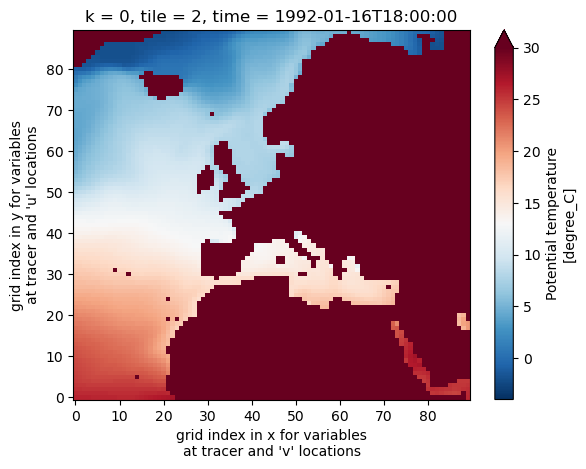

In [43]:
%%time
ds['THETA'].isel(time=0, k=0, tile=2).plot(cmap='RdBu_r', vmin=-4, vmax=30)

In [46]:
ds['THETA'].isel(time=0, k=0, tile=2).attrs

{'long_name': 'Potential temperature ',
 'units': 'degree_C',
 'coverage_content_type': 'modelResult',
 'standard_name': 'sea_water_potential_temperature',
 'comment': 'Sea water potential temperature is the temperature a parcel of sea water would have if moved adiabatically to sea level pressure. Note: the equation of state is a modified UNESCO formula by Jackett and McDougall (1995), which uses the model variable potential temperature as input assuming a horizontally and temporally constant pressure of $p_0=-g \rho_{0} z$.',
 'valid_min': -2.2909388542175293,
 'valid_max': 36.032955169677734,
 'origname': 'THETA',
 'fullnamepath': '/THETA',
 'Maps': ()}